# Aluno: Clésio de Araújo Gonçalves

In [1]:
import glob
import numpy as np
from skimage.io import imread_collection
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Carregando as imagens da base
entrada = glob.glob('imagens/*.jpg')
imagens = imread_collection(entrada)

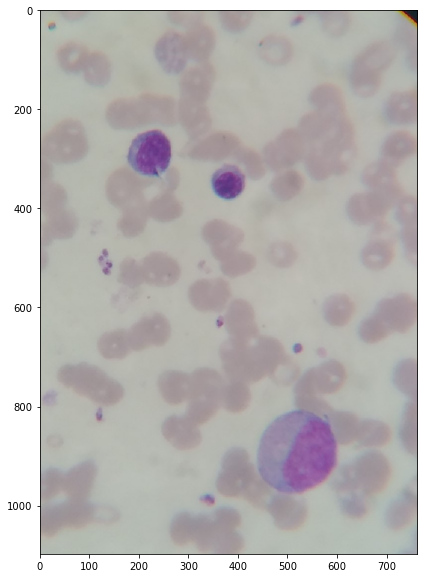

In [3]:
# exibe qualquer imagem
plt.figure(figsize=(12,10))
plt.imshow(imagens[2])

In [4]:
# 2, 5, 9, 16, 18
imagens = imagens[2], imagens[5], imagens[9] # Pega só 3 imagens

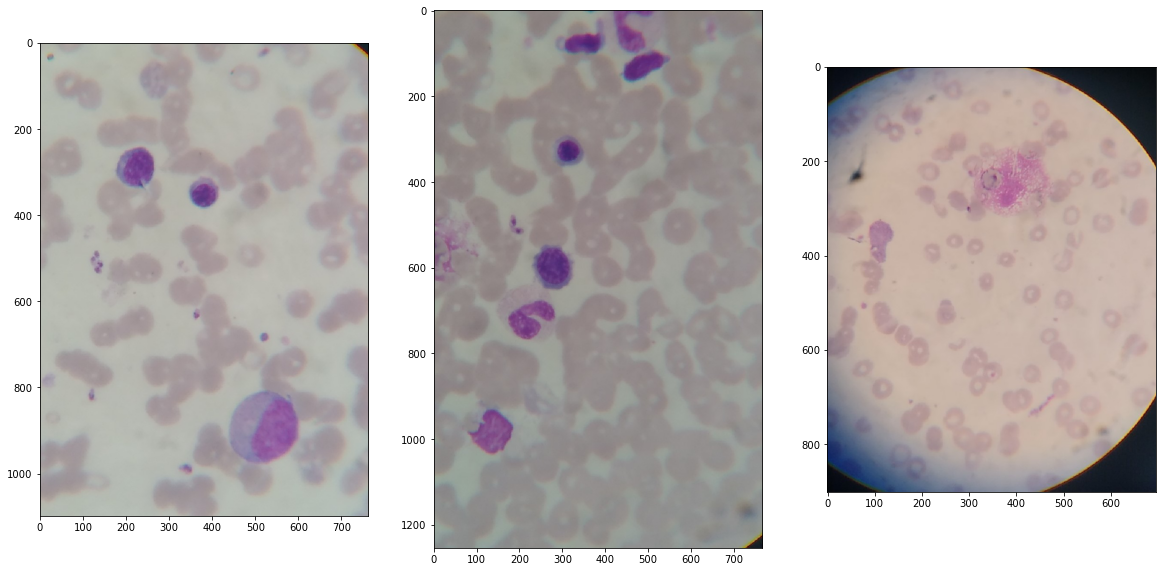

In [5]:
def exibe_imagens(imgs):
    fig, ax = plt.subplots(1, 3, figsize=(20, 15))
    ax = ax.ravel()

    for i in range(len(imgs)):
        ax[i].imshow(imgs[i], cmap="gray")
        
exibe_imagens(imagens)

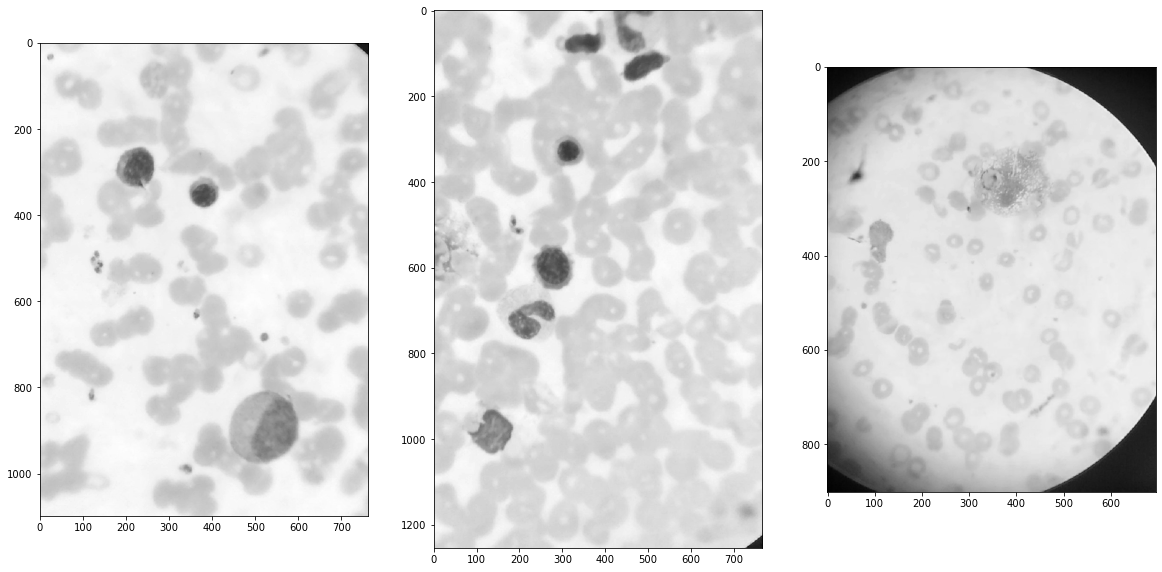

In [6]:
# Imagens em escala de cinza
def escala_cinza(imgs):
    imagens = []
    for i in range(len(imgs)):
        imagens.append(np.uint8(rgb2gray(imgs[i])*255))
    
    return imagens

imagens_cinza = escala_cinza(imagens)
exibe_imagens(imagens_cinza)

# 1. Segmentação baseada em agrupamento (K-Means)

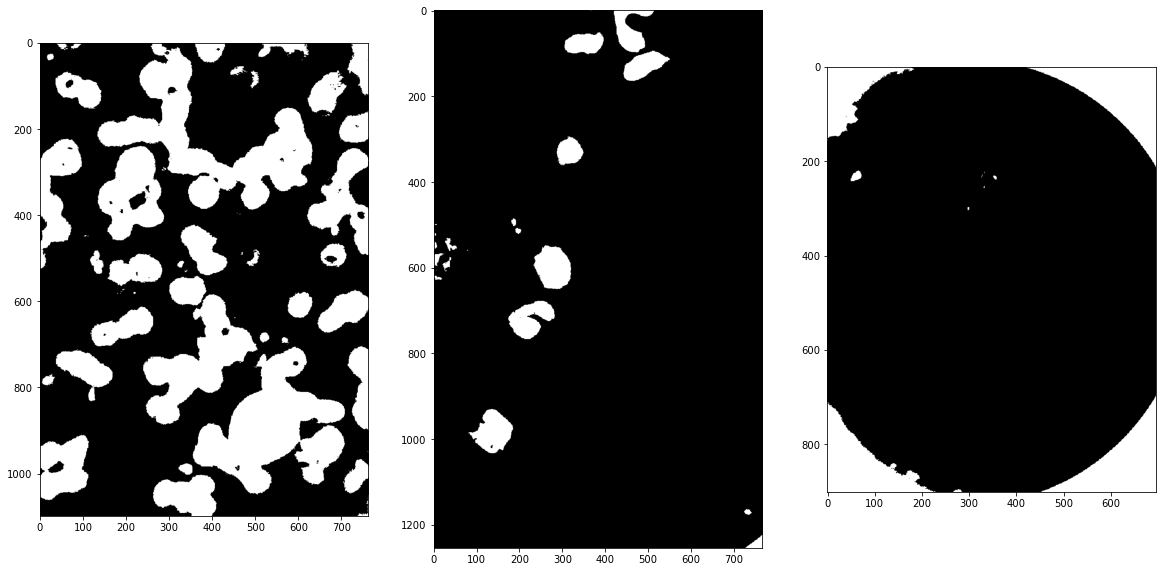

In [7]:
from sklearn.cluster import KMeans

imgs_kmeans = []

# Segmentação de todas as imagens da lista
for i in range(len(imagens_cinza)):
    model = KMeans(n_clusters=2, random_state=0).fit(np.reshape(imagens_cinza[i], (-1, 1)))
    segmented = model.predict(np.reshape(imagens_cinza[i], (-1, 1)))
    segmented = np.reshape(segmented, (imagens_cinza[i].shape[0], imagens_cinza[i].shape[1]))
    if i == 0:
        segmented = 1 - segmented # Negativo da imagem
    imgs_kmeans.append(segmented)
    
exibe_imagens(imgs_kmeans)

## 1.1 Preenchendo as regiões detectadas

In [8]:
from scipy import ndimage as ndi

def preenchendo_bordas(imgs_segmentacao):

    imgs_fill_leish = []

    for i in range(len(imgs_segmentacao)):
        imgs_fill_leish.append(ndi.binary_fill_holes(imgs_segmentacao[i])) # Preenche os buracos de regiões fechadas de imagens binárias
        
    return imgs_fill_leish

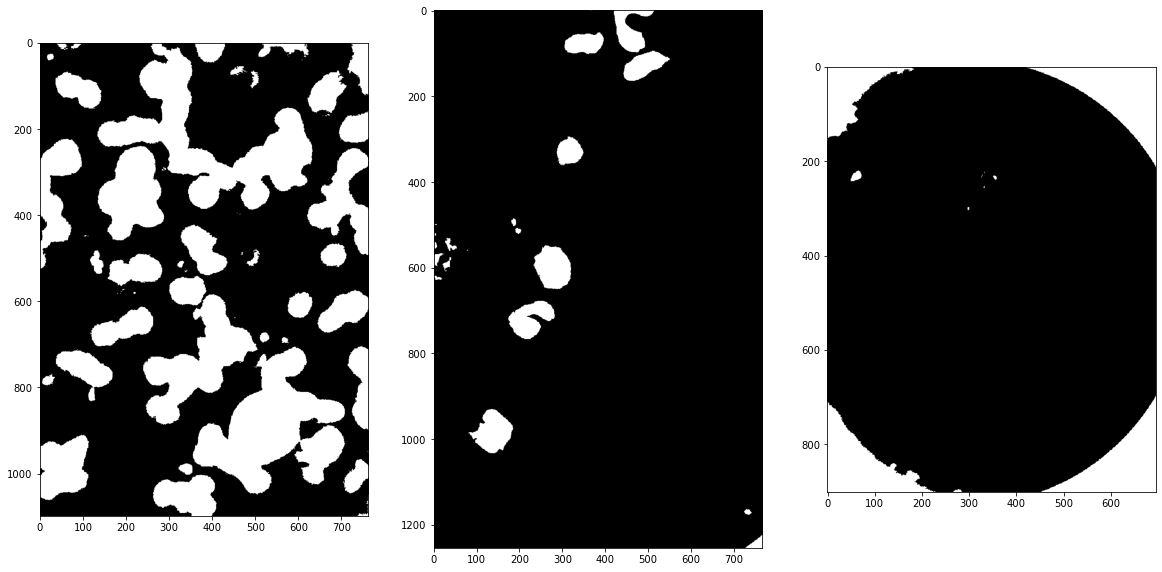

In [9]:
imgs_fill_leish = preenchendo_bordas(imgs_kmeans)
exibe_imagens(imgs_fill_leish)

## 1.2 Remoção de grandes regiões segmentadas

In [10]:
def remocao_grandes_regioes(imgs, numero_pixels):
    
    number_of_pixels = numero_pixels # As regioes que tiverem mais de numero_pixels pixels serão removidas
    imgs_remocao = []
    
    for x in range(len(imgs)):
        label_objects, nb_labels = ndi.label(imgs[x]) # Criando labels com as diferentes regiões da imagem
        new_image = np.zeros((label_objects.shape[0],label_objects.shape[1])) # Criando a nova imagem que receberá o resultado
        for i in range(1, nb_labels+1):
            quant = np.sum(label_objects[:] == i) # Calculando o número de pixels da região de label i
            if(quant < number_of_pixels): # Fazendo a limiarização para remover as regiões com menos pixels que a variável
                new_image[label_objects[:] == i] = 1 # Os pixels da nova imagem receberão valor 1 nas posições que a região possui label igual a i
        imgs_remocao.append(new_image)
    
    return imgs_remocao

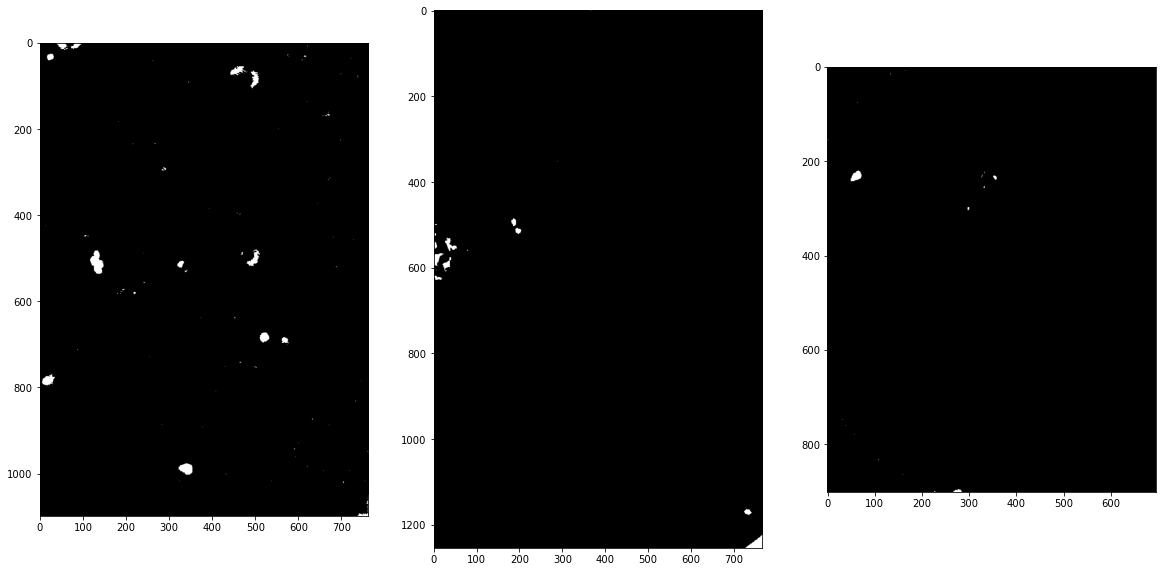

In [11]:
imgs_remocao12 = remocao_grandes_regioes(imgs_fill_leish, 1500)
exibe_imagens(imgs_remocao12)

## 1.3 Remoção de pequenas regiões segmentadas

In [12]:
def remocao_pequenas_regioes(imgs, numero_pixels):
    number_of_pixels = numero_pixels #As regioes que tiverem menos de numero_pixels pixels serão removidas
    imgs_remocao = []
    for x in range(len(imgs)):
        label_objects, nb_labels = ndi.label(imgs[x]) #Criando labels com as diferentes regiões da imagem
        new_image2 = np.zeros((label_objects.shape[0], label_objects.shape[1])) #Criando a nova imagem que receberá o resultado
        for i in range(1, nb_labels):
            quant = np.sum(label_objects[:] == i) #Calculando o número de pixels da região de label i
            if(quant > number_of_pixels): #Fazendo a limiarização para remover as regiões com menos pixels que a variável
                new_image2[label_objects[:] == i] = 1 #Os pixels da nova imagem receberão valor 1 nas posições que a região possui label igual a i
        imgs_remocao.append(new_image2)
        
    return imgs_remocao

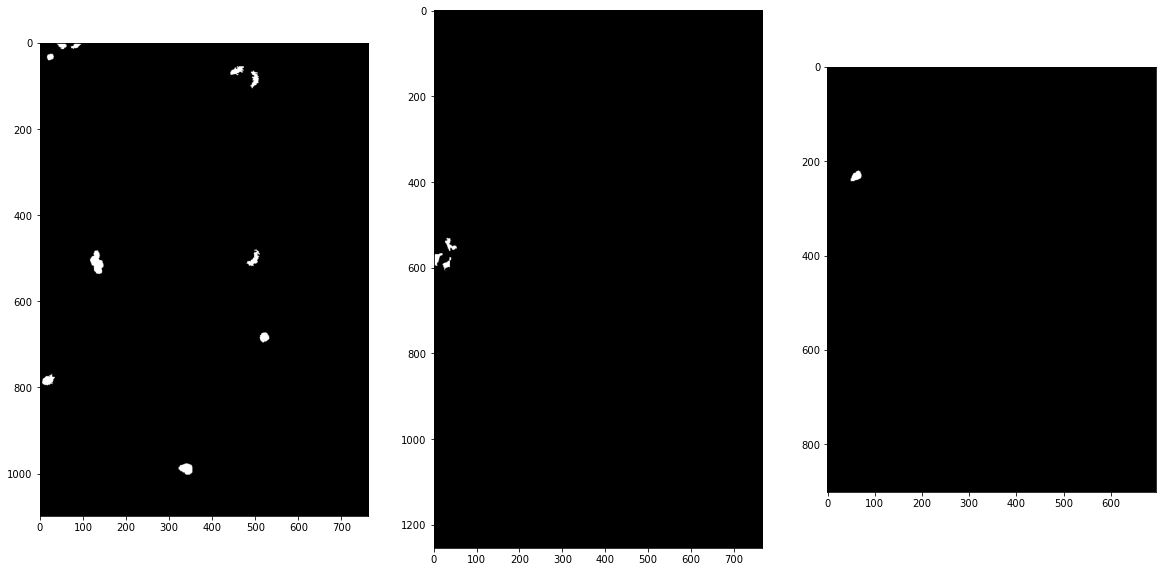

In [13]:
imgs_remocao13 = remocao_pequenas_regioes(imgs_remocao12, 180)
exibe_imagens(imgs_remocao13)

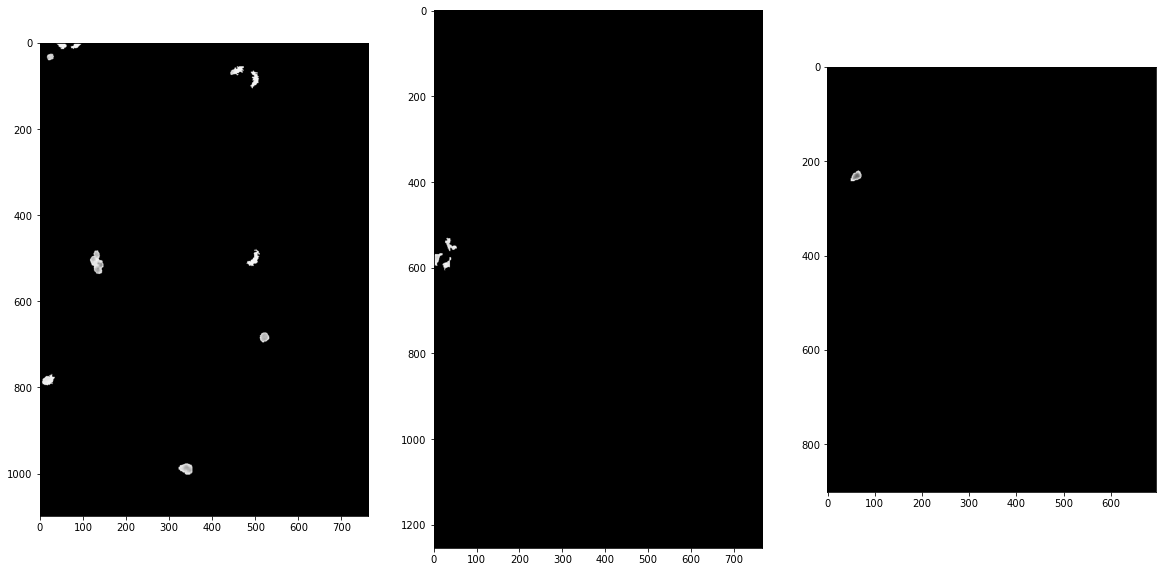

In [14]:
producto = [a * b for a, b in zip(imagens_cinza, imgs_remocao13)]
exibe_imagens(producto)

## 1.4 Erosão

In [15]:
import cv2 as cv
import numpy as np

def erosao_imagens(imgs, kernel):
    imgs_erosao = []
    for i in range(len(imgs)):
        erosao = cv.erode(imgs[i], kernel)
        imgs_erosao.append(erosao)
        
    return imgs_erosao

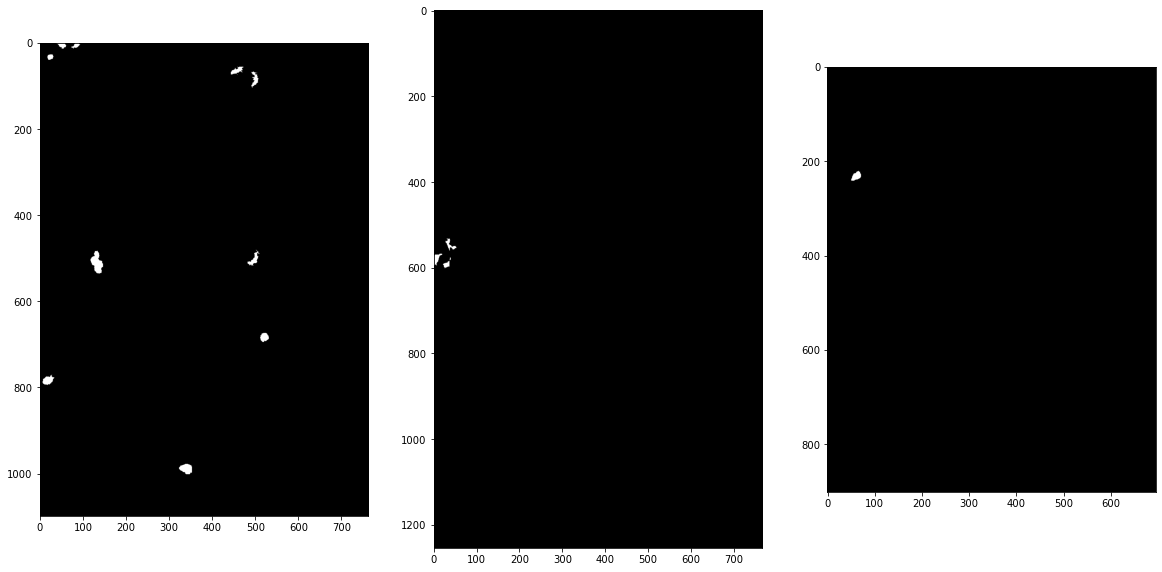

In [16]:
kernel1 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)) # kernel utilizado

imgs_erosao = erosao_imagens(imgs_remocao13, kernel1)
exibe_imagens(imgs_erosao)

## 1.5 Dilatação

In [17]:
def dilatacao_imagens(imgs, kernel):
    imgs_dilatacao = []
    for i in range(len(imgs)):
        dilatacao = cv.dilate(imgs[i], kernel)
        imgs_dilatacao.append(dilatacao)
        
    return imgs_dilatacao

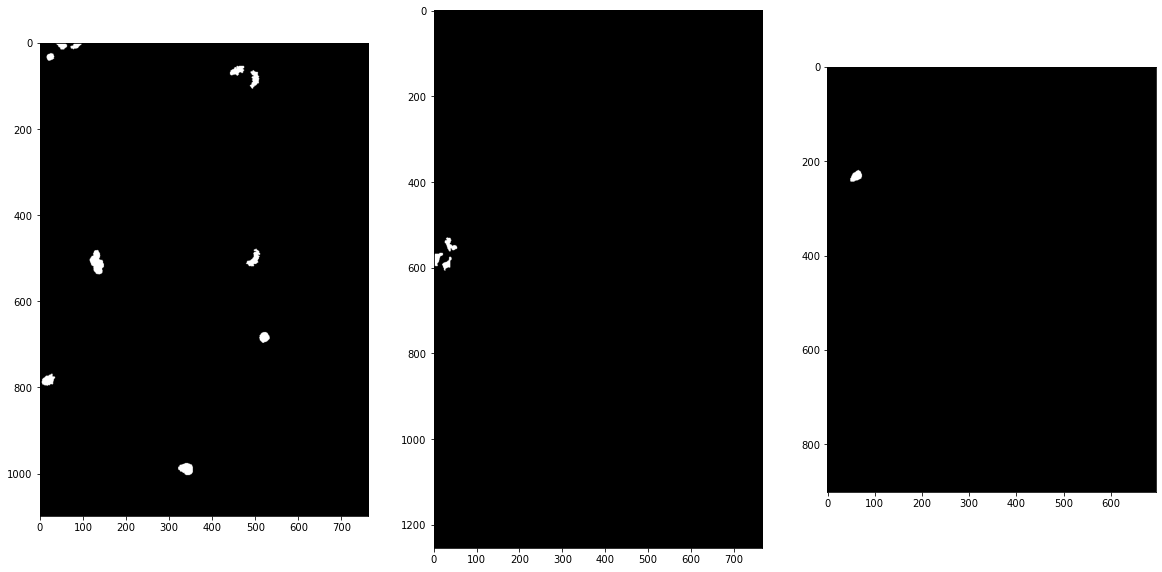

In [18]:
imgs_dilatacao = dilatacao_imagens(imgs_remocao13, kernel1)
exibe_imagens(imgs_dilatacao)

## 1.6 Abertura

In [19]:
# erosion followed by dilation
def abertura_imagens(imgs, kernel):
    imgs_abertura = []
    for i in range(len(imgs)):
        abertura = cv.morphologyEx(imgs[i], cv.MORPH_OPEN, kernel)
        imgs_abertura.append(abertura)
        
    return imgs_abertura

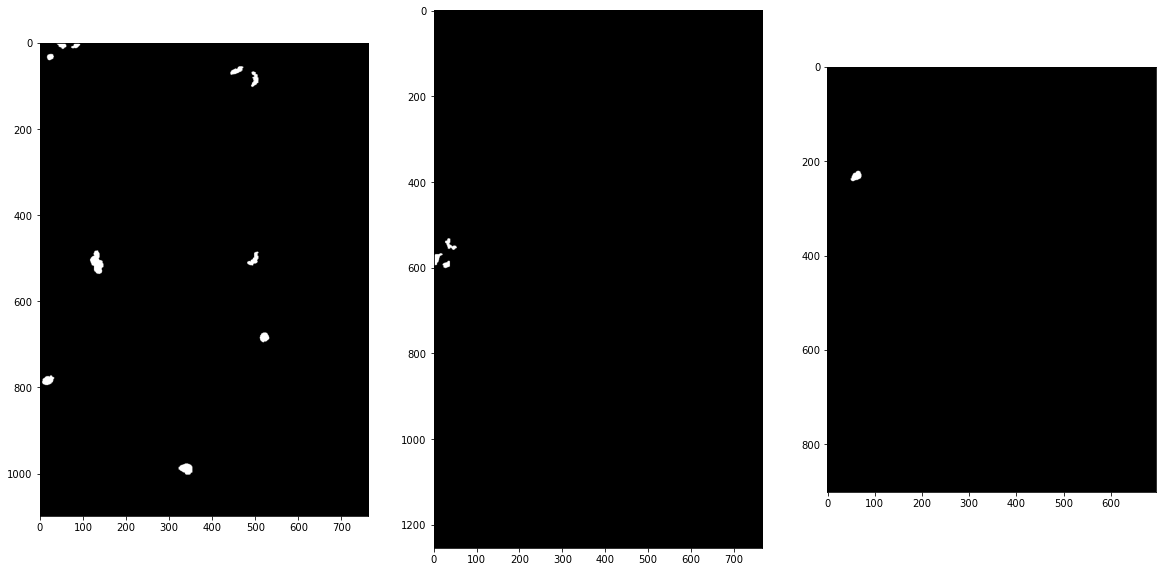

In [20]:
kernel2 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5)) # kernel utilizado
imgs_abertura = abertura_imagens(imgs_remocao13, kernel2)
exibe_imagens(imgs_abertura)

## 1.7 Fechamento

In [21]:
# Dilation followed by Erosion
def fechamento_imagens(imgs, kernel):
    imgs_fechamento = []
    for i in range(len(imgs)):
        fechamento = cv.morphologyEx(imgs[i], cv.MORPH_CLOSE, kernel)
        imgs_fechamento.append(fechamento)
        
    return imgs_fechamento

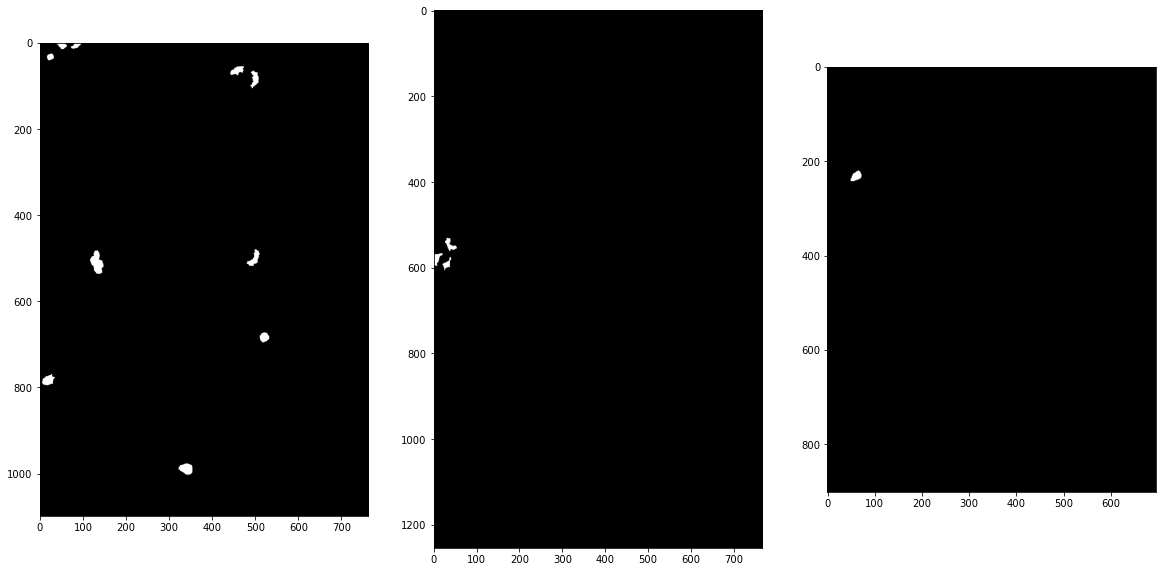

In [22]:
imgs_fechamento = fechamento_imagens(imgs_remocao13, kernel2)
exibe_imagens(imgs_fechamento)

# 2. Segmentação baseada em deteção de bordas

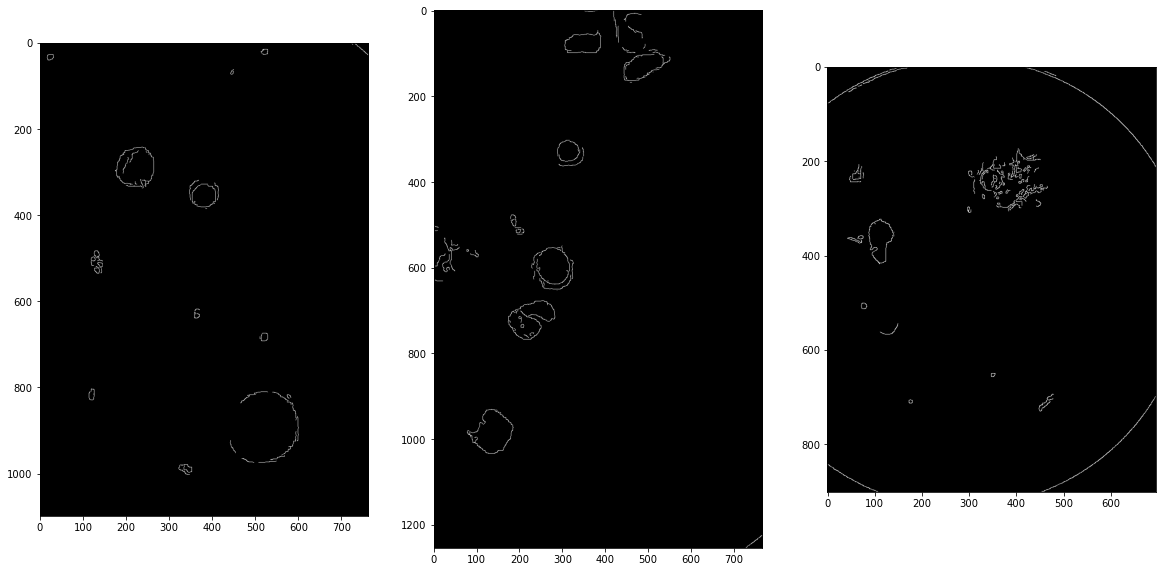

In [23]:
from skimage.feature import canny

imgs_arestas = []

for i in range(len(imagens_cinza)):
    imgs_arestas.append(canny(imagens_cinza[i])) # Aplicando o detector de bordas de canny

exibe_imagens(imgs_arestas)

## 2.1 Preenchendo as bordas detectadas

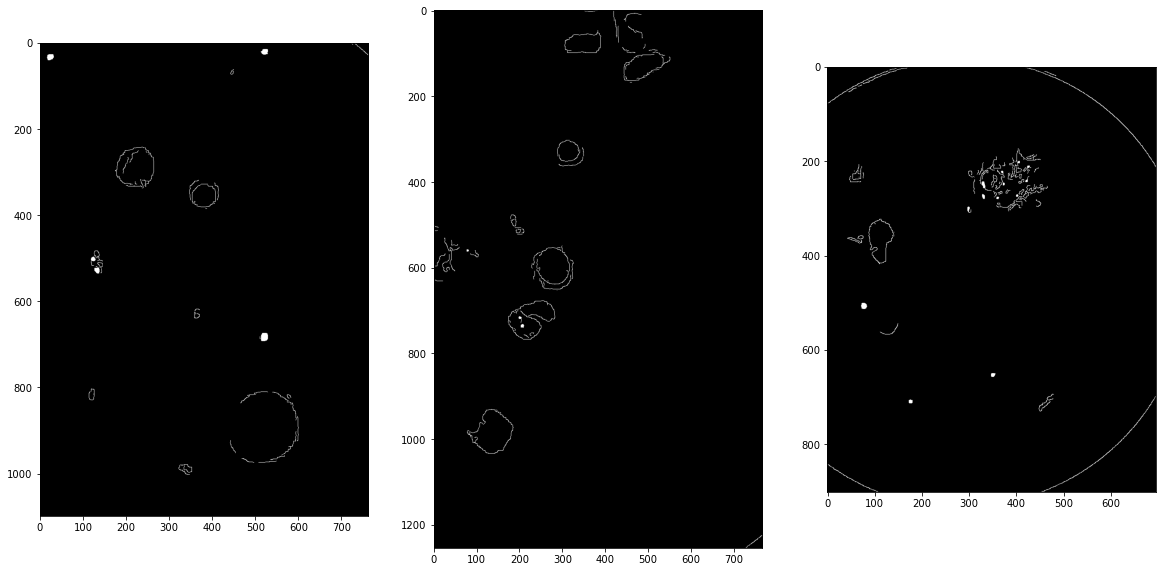

In [24]:
imgs_fill_leish2 = preenchendo_bordas(imgs_arestas)
exibe_imagens(imgs_fill_leish2)

## 2.2 Remoção de pequenas regiões segmentadas

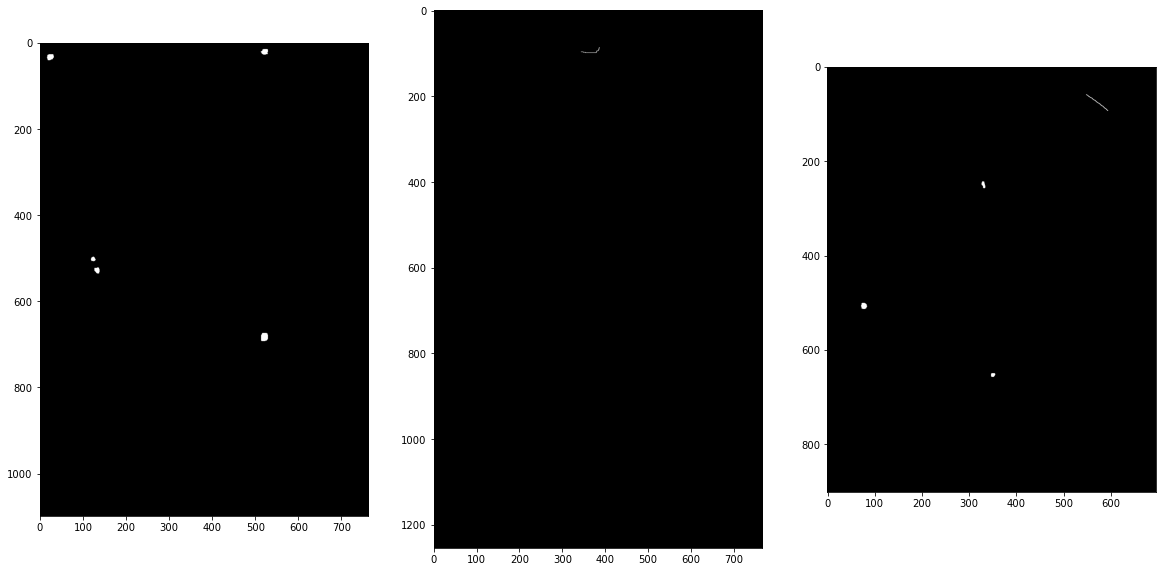

In [25]:
imgs_remocao22 = remocao_pequenas_regioes(imgs_fill_leish2, 58)
exibe_imagens(imgs_remocao22)

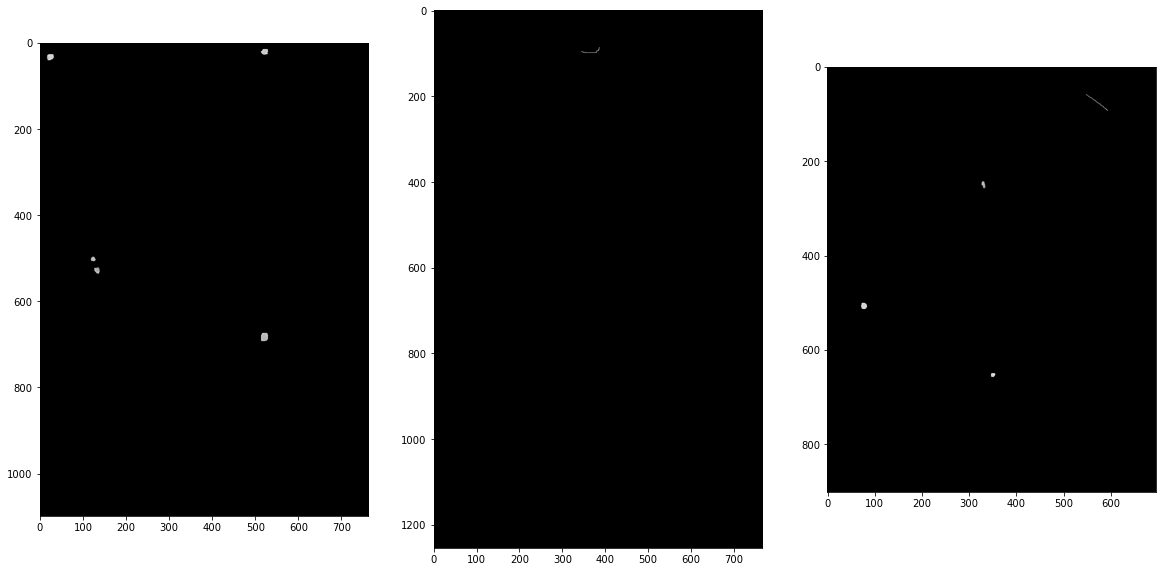

In [26]:
produto2 = [a * b for a, b in zip(imagens_cinza, imgs_remocao22)]
exibe_imagens(produto2)

## 2.3 Erosão

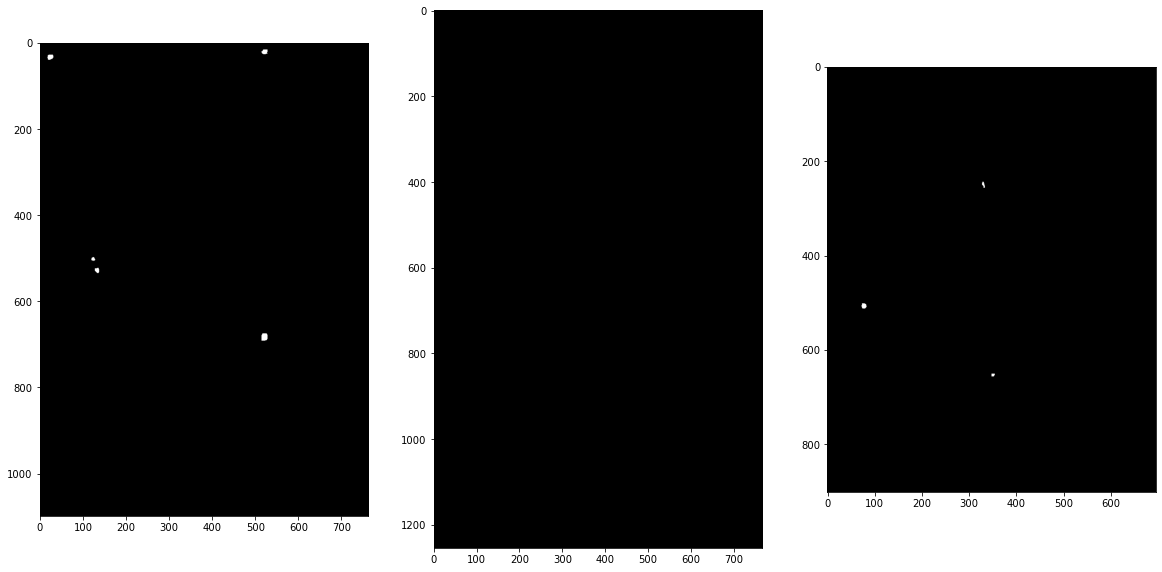

In [27]:
imgs_erosao = erosao_imagens(imgs_remocao22, kernel1)
exibe_imagens(imgs_erosao)

## 2.4 Dilatação

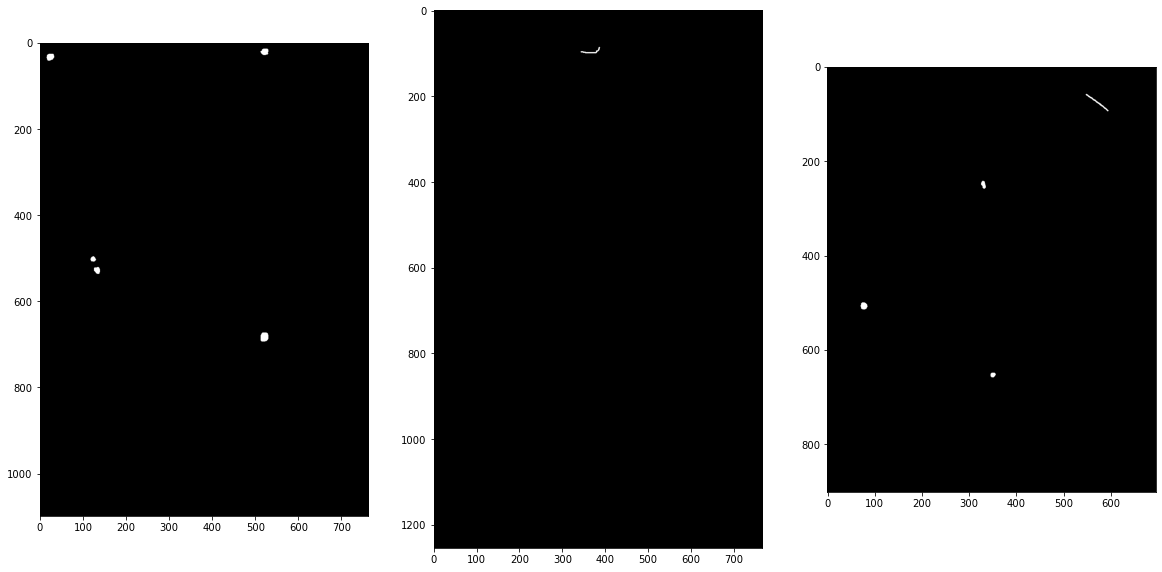

In [28]:
imgs_dilatacao = dilatacao_imagens(imgs_remocao22, kernel1)
exibe_imagens(imgs_dilatacao)

## 2.5 Abertura

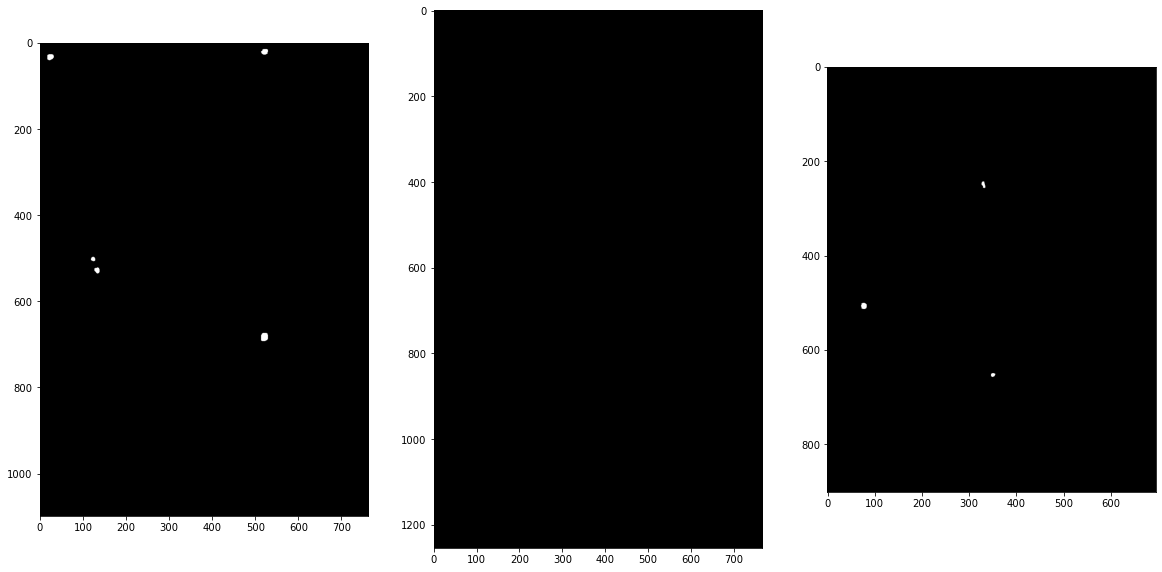

In [29]:
imgs_abertura = abertura_imagens(imgs_remocao22, kernel2)
exibe_imagens(imgs_abertura)

## 2.6 Fechamento

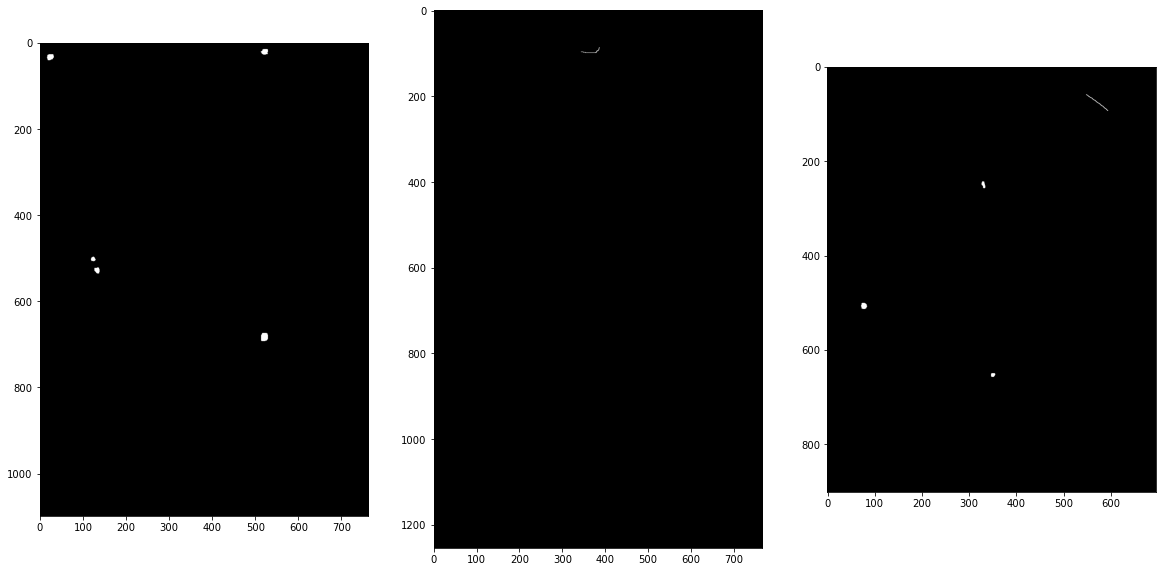

In [30]:
imgs_fechamento = fechamento_imagens(imgs_remocao22, kernel2)
exibe_imagens(imgs_fechamento)

# 3. Segmentação baseada em limiarização

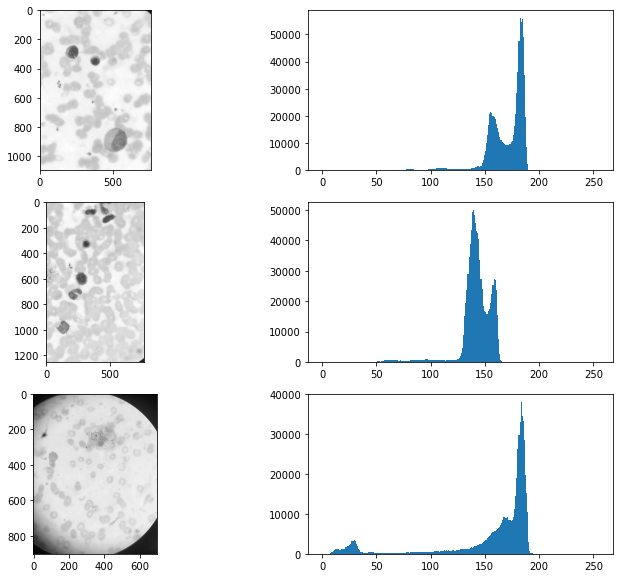

In [31]:
# Exibe o histograma das imagens
def histograma():
    fig, ax = plt.subplots(3,2,figsize=(12,10))
    ax[0,0].imshow(imagens_cinza[0],cmap='gray')
    ax[1,0].imshow(imagens_cinza[1],cmap='gray')
    ax[2,0].imshow(imagens_cinza[2],cmap='gray')
    ax[0,1].hist(imagens_cinza[0].ravel(),range(256))
    ax[1,1].hist(imagens_cinza[1].ravel(),range(256))
    ax[2,1].hist(imagens_cinza[2].ravel(),range(256))
    plt.show()

histograma()

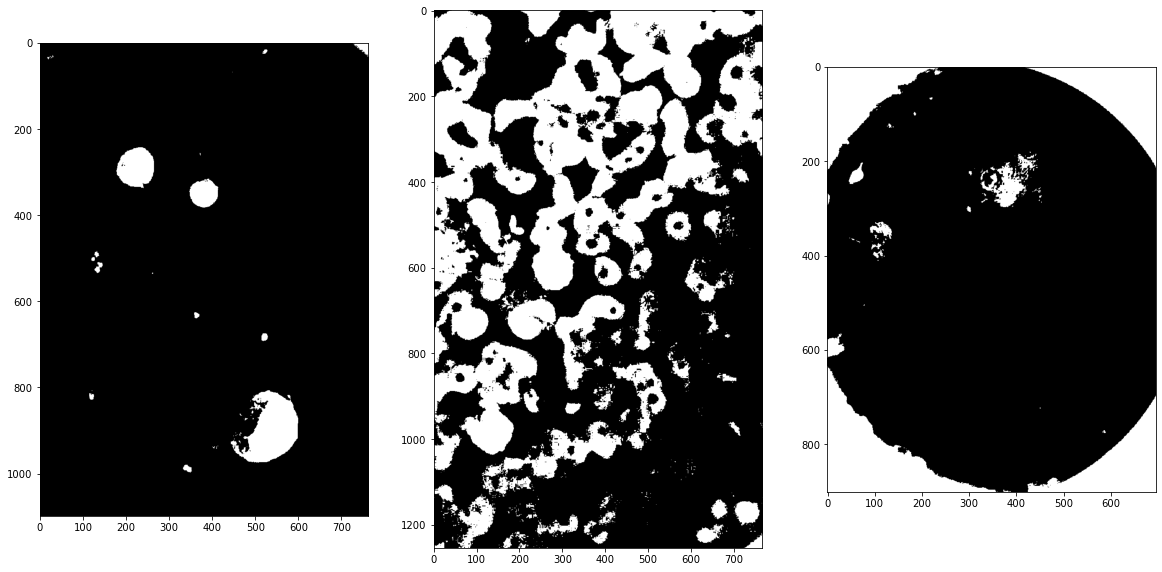

In [32]:
threshold = 140

imgs_threshold = []

for i in range(len(imagens_cinza)):
    imgs_threshold.append(imagens_cinza[i] < threshold)

exibe_imagens(imgs_threshold)

## 3.1 Preenchendo as regiões

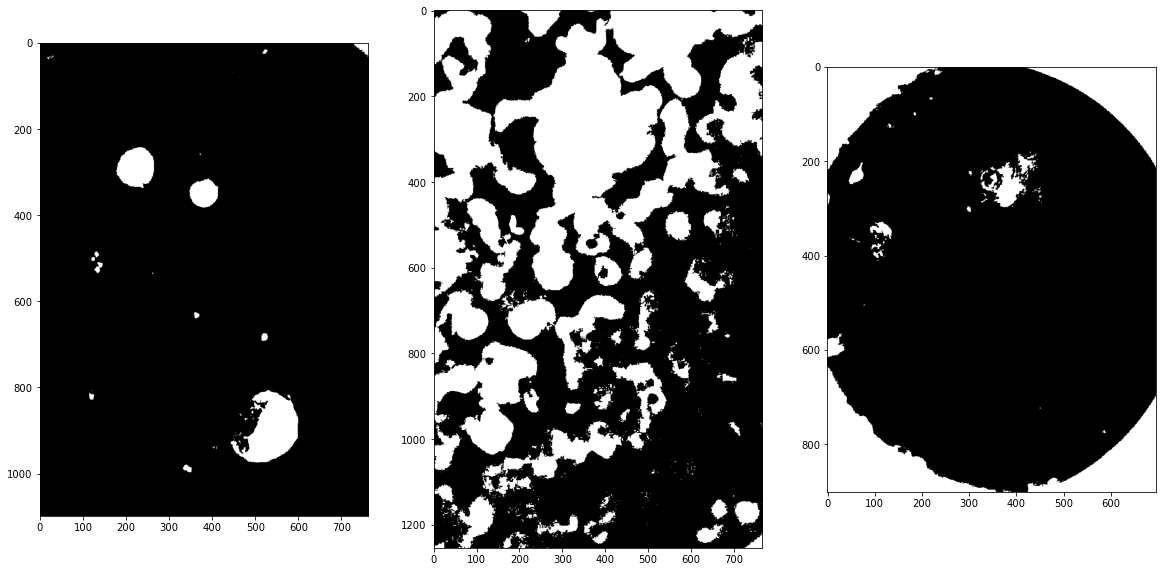

In [33]:
imgs_fill_leish3 = preenchendo_bordas(imgs_threshold)
exibe_imagens(imgs_fill_leish3)

## 3.2 Remoção de grandes regiões

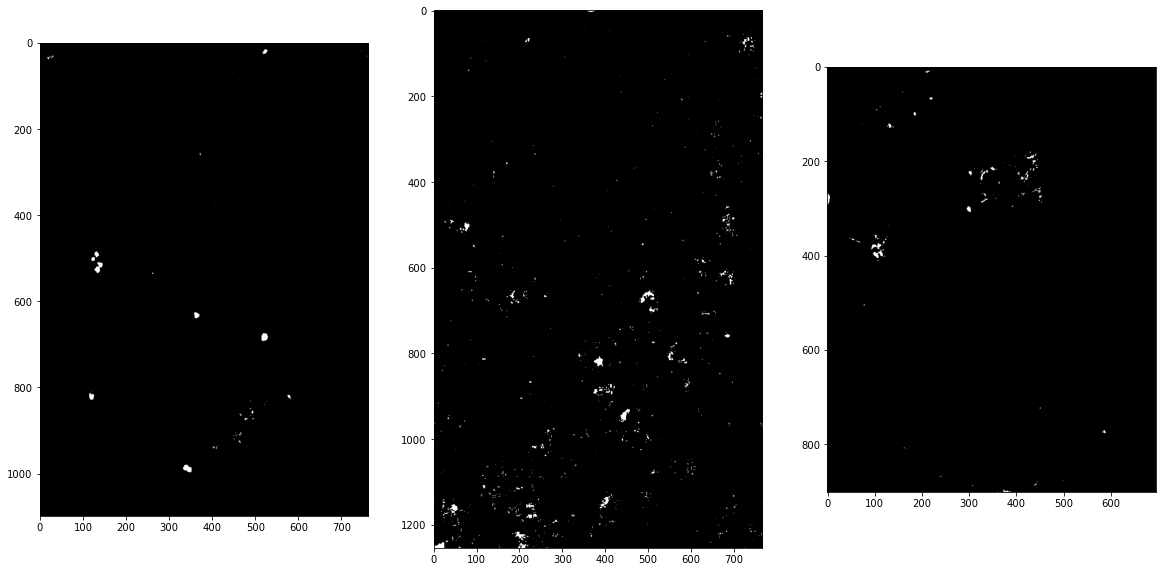

In [34]:
imgs_remocao32 = remocao_grandes_regioes(imgs_fill_leish3, 300)
exibe_imagens(imgs_remocao32)

## 3.3 Remoção de pequenas regiões

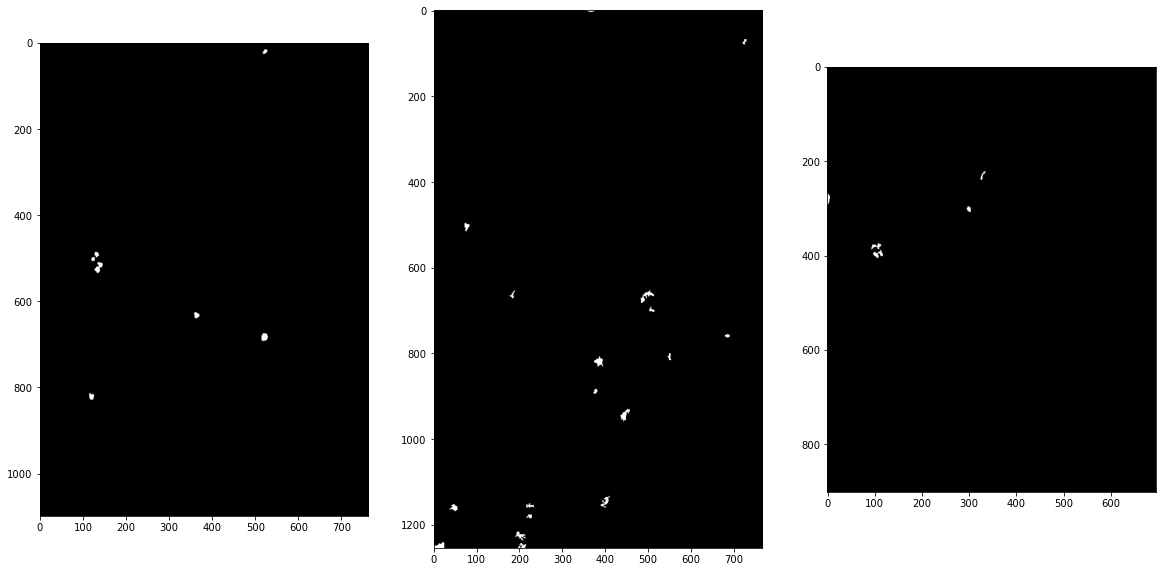

In [43]:
imgs_remocao33 = remocao_pequenas_regioes(imgs_remocao32, 60)
exibe_imagens(imgs_remocao33)

## 3.4 Erosão

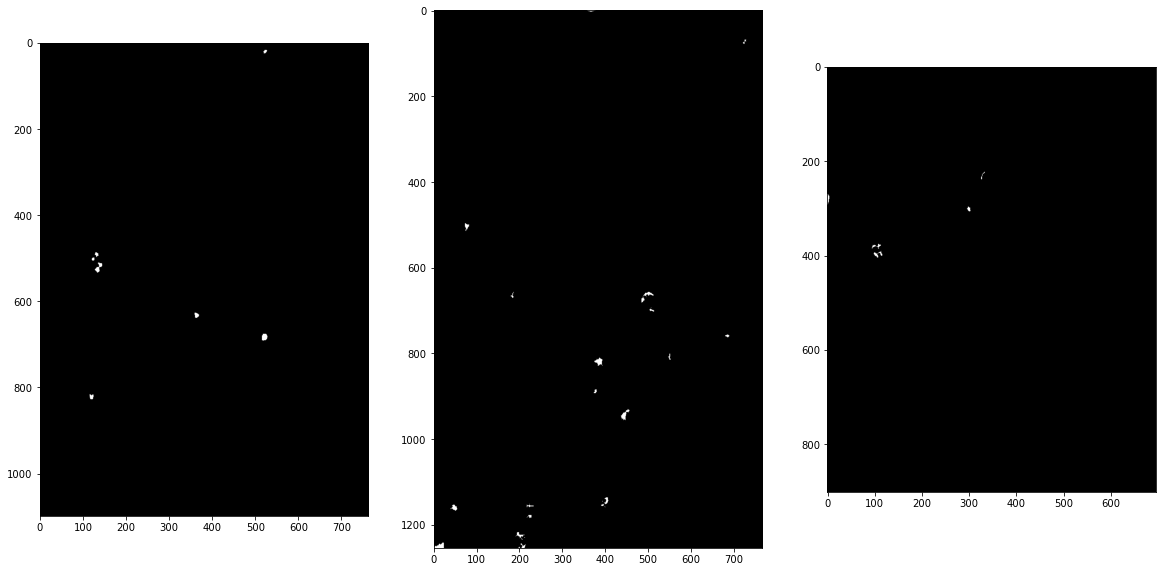

In [44]:
imgs_erosao = erosao_imagens(imgs_remocao33, kernel1)
exibe_imagens(imgs_erosao)

## 3.5 Dilatação

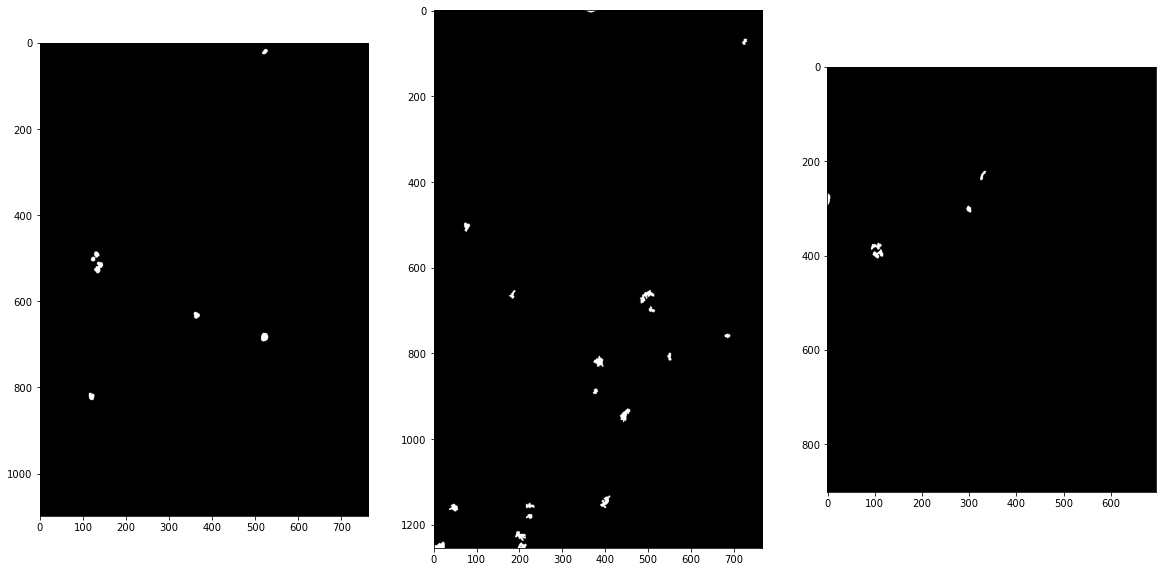

In [45]:
imgs_dilatacao = dilatacao_imagens(imgs_remocao33, kernel1)
exibe_imagens(imgs_dilatacao)

## 3.6 Abertura

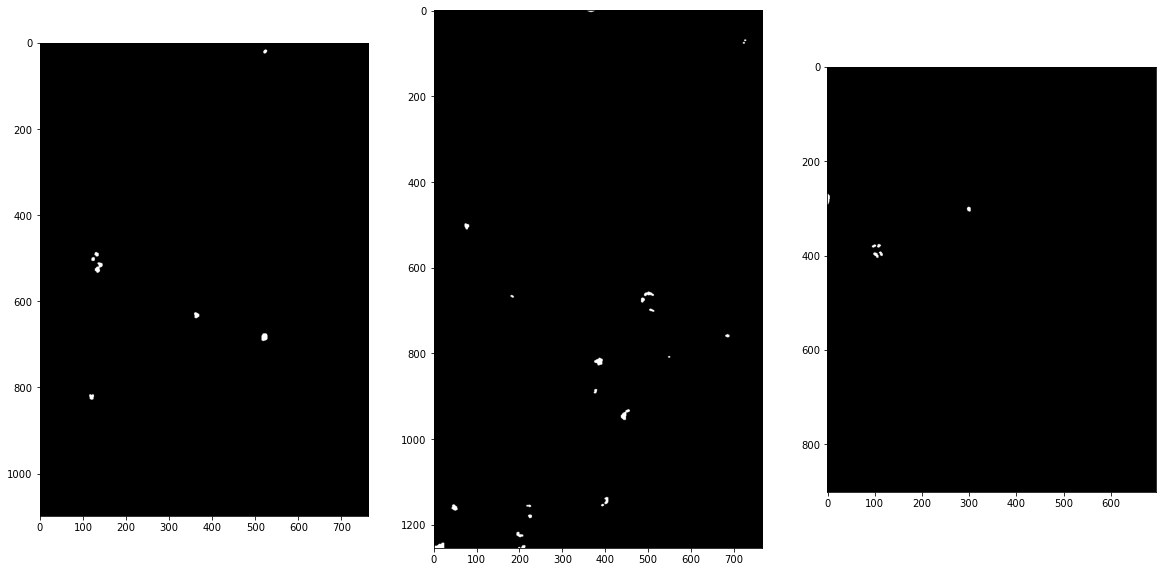

In [46]:
imgs_abertura = abertura_imagens(imgs_remocao33, kernel2)
exibe_imagens(imgs_abertura)

## 3.7 Fechamento

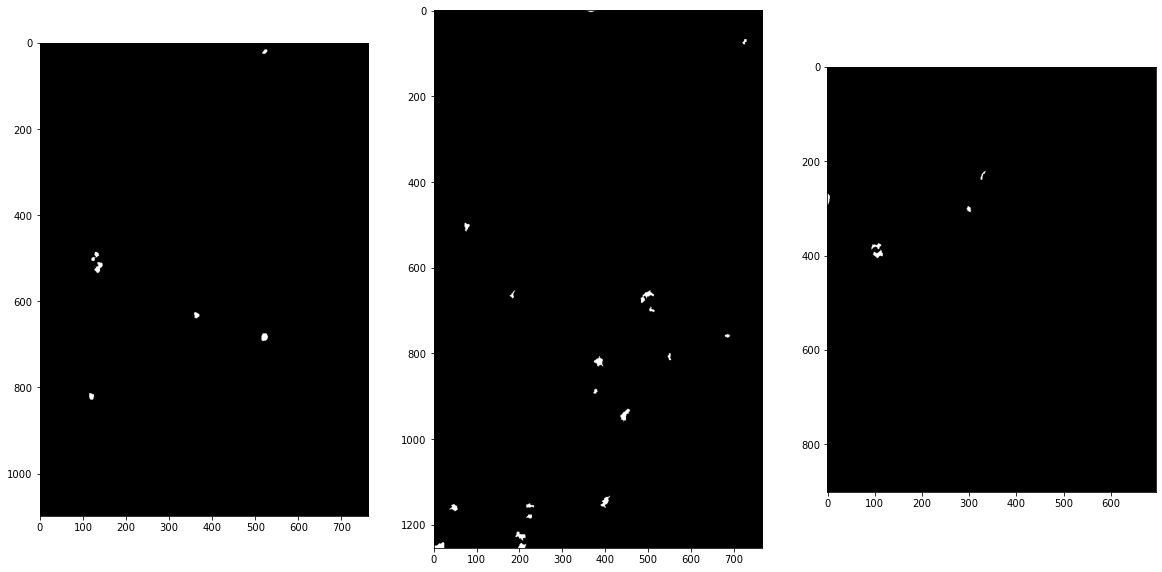

In [47]:
imgs_fechamento = fechamento_imagens(imgs_remocao33, kernel2)
exibe_imagens(imgs_fechamento)

## 3.4 Metodos que calculam automaticamente um valor de threshold

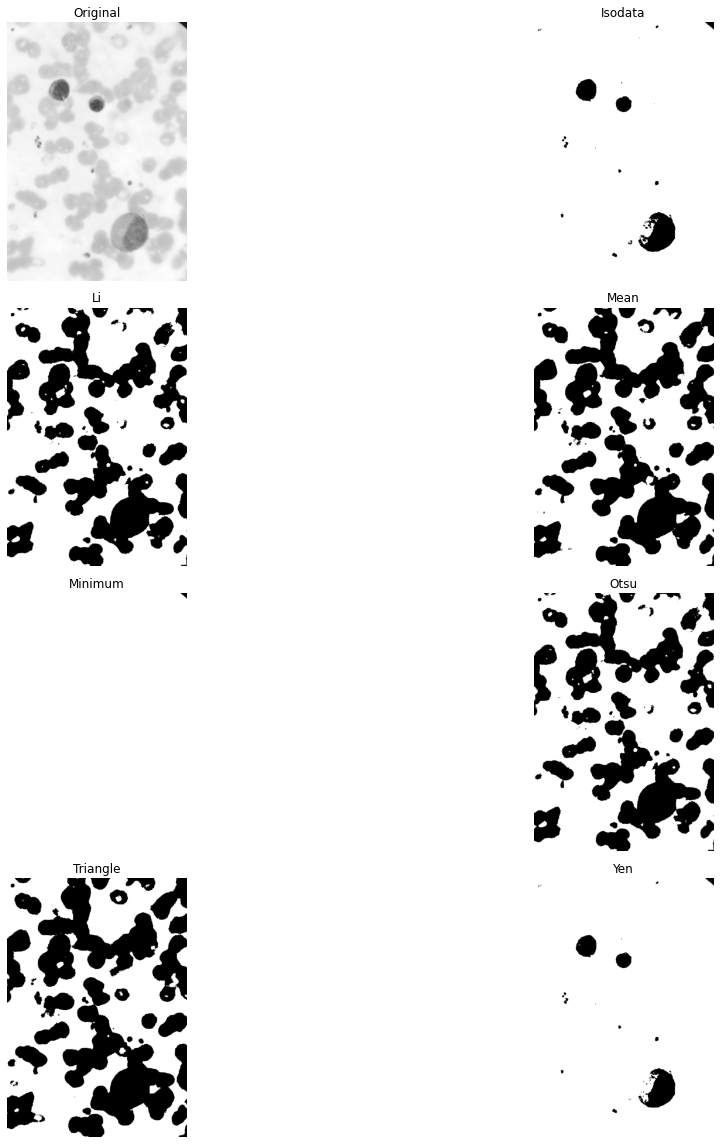

In [40]:
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(imagens_cinza[0], figsize=(20, 16), verbose=False)
plt.show()

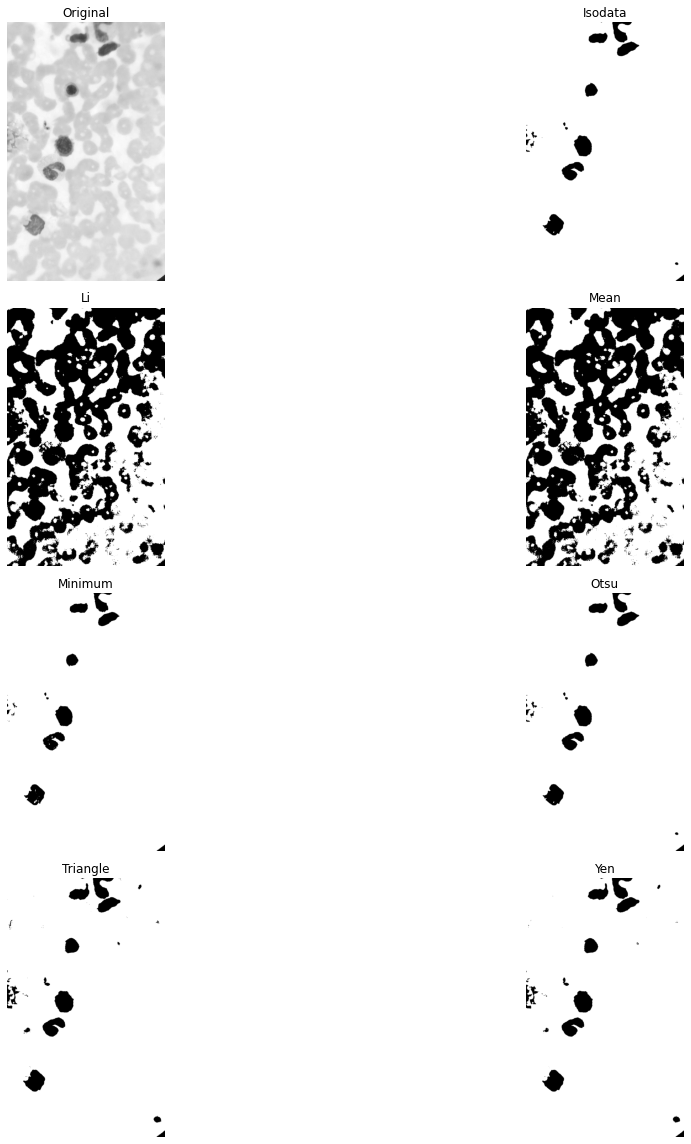

In [41]:
fig, ax = try_all_threshold(imagens_cinza[1], figsize=(20, 16), verbose=False)
plt.show()

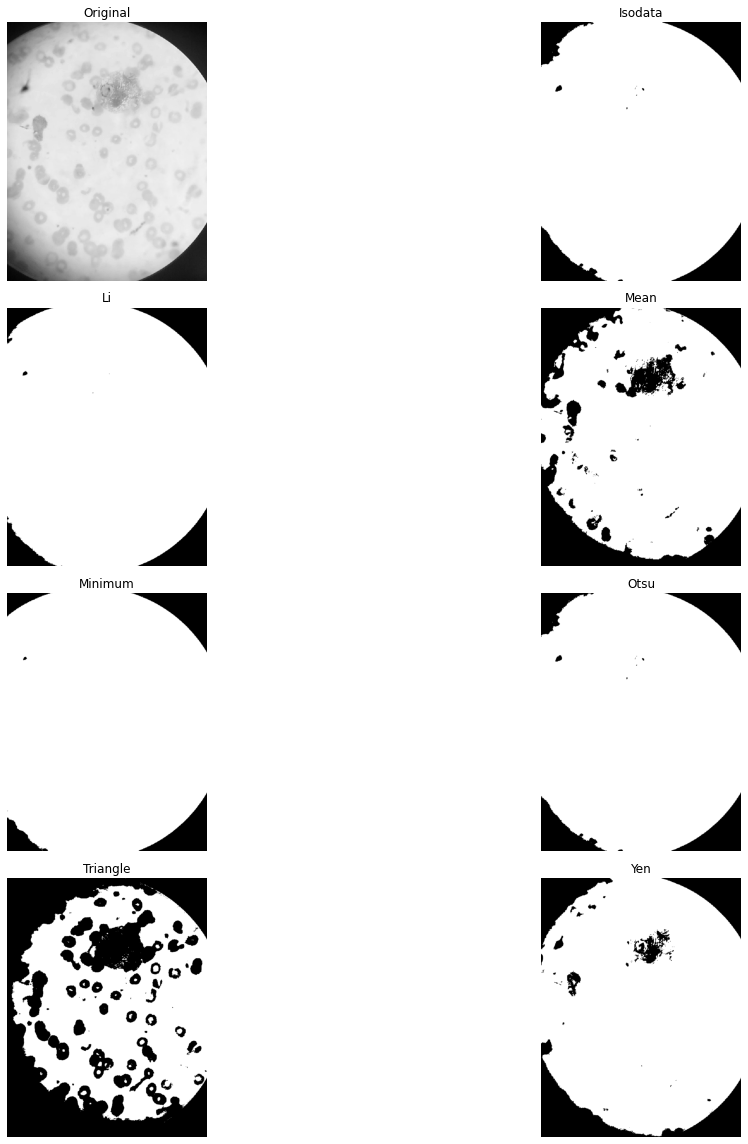

In [42]:
fig, ax = try_all_threshold(imagens_cinza[2], figsize=(20, 16), verbose=False)
plt.show()